# Neurosynth correlations #

This notebook is used to correlate brain states with topic maps obtained from the Neurosynth repository (https://neurosynth.org/).

| Topic map     | Number of studies|
| :-------------|:-------------:| 
| emotional     | 1708 |
| music   | 163     | 
| attention | 1831    |
| social cognition    | 220|
| autobiographical memory  | 84    | 
| anxiety | 449  |
| language  | 1101 |
| reward | 922  | 
| pain | 516 |
| happy | 225  |
| somatosensory | 674 |

Brain atlas: Schaefer 2018., 400 ROIs, 2mm resolution [(atlas Github repository)](https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal)

**Last update:** 29.08.2021


### Step 0: Loading libraries ###

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from nilearn import input_data, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.plotting import plot_roi
from nilearn.image import clean_img, load_img, concat_imgs
import plotly.graph_objects as go
from scipy.stats import pearsonr

### Step 1: Creating parcellation ###

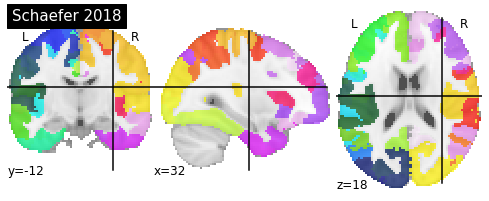

In [3]:
#Loading atlas
atlas_path = '/home/iga/BrainStates/brain-states/Analysis/atlas/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz'

#Creating parcellation
schaefer_atlas = input_data.NiftiLabelsMasker(atlas_path)
parcellation = np.asarray([schaefer_atlas, "Schaefer_2018", 400])

#Plotting atlas
plotting.plot_roi(atlas_path, title = 'Schaefer 2018')

### Step 2: Loading and concatenating data ###

In [4]:
#Loading data
input_path = '/home/iga/BrainStates/ds003059/data/Neurosynth'

emotion = load_img(f'{input_path}/emotional_uniformity-test_z_FDR_0.01.nii.gz')
music = load_img(f'{input_path}/music_uniformity-test_z_FDR_0.01.nii.gz')
attention = load_img(f'{input_path}/attention_uniformity-test_z_FDR_0.01.nii.gz')
soc_cog = load_img(f'{input_path}/social cognition_uniformity-test_z_FDR_0.01.nii.gz')
au_mem = load_img(f'{input_path}/autobiographical memory_uniformity-test_z_FDR_0.01.nii.gz')
anxiety = load_img(f'{input_path}/anxiety_uniformity-test_z_FDR_0.01.nii.gz')
lang = load_img(f'{input_path}/language_uniformity-test_z_FDR_0.01.nii.gz')
reward= load_img(f'{input_path}/reward_uniformity-test_z_FDR_0.01.nii.gz')
pain = load_img(f'{input_path}/pain_uniformity-test_z_FDR_0.01.nii.gz')
happy = load_img(f'{input_path}/happy_uniformity-test_z_FDR_0.01.nii.gz')
somsen = load_img(f'{input_path}/somatosensory_uniformity-test_z_FDR_0.01.nii.gz')

#Concatenating images
imgs = [emotion, music, attention, soc_cog, au_mem, anxiety, lang, reward, pain, happy, somsen]
image = concat_imgs(imgs)

#Printing final image shape
image.shape

(91, 109, 91, 11)

### Step 3: Timeseries extraction ###

In [5]:
#Signal extraction
timeseries = parcellation[0].fit_transform(image, confounds=None)

t = timeseries.T
timeseries.shape

(11, 400)

### Step 4: Calculating correlation within Neurosynth topic maps ###

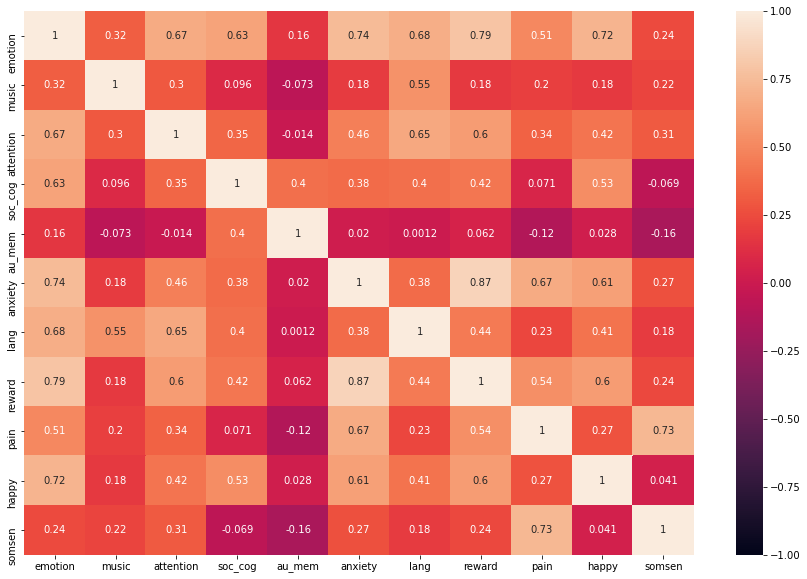

In [7]:
#Creating dataframe
neurosynth = {'emotion': timeseries[0],
        'music': timeseries[1],
        'attention': timeseries[2],
        'soc_cog': timeseries[3],
        'au_mem': timeseries[4],
        'anxiety': timeseries[5],
        'lang': timeseries[6],
        'reward': timeseries[7],
        'pain': timeseries[8],
        'happy': timeseries[9],
        'somsen': timeseries[10]
        }

df = pd.DataFrame(neurosynth)

#Calculating correlation
corrMatrix = df.corr()

#Plotting correlation
plt.figure(figsize = (15,10))
ax = sn.heatmap(corrMatrix, vmin = -1, vmax = 1, annot=True)
plt.savefig('Figures/neurosynth_heatmap.png', dpi=300, bbox_inches='tight')

### Step 5: Calculating correlation with Neurosynth topic maps for 4 brain states ###

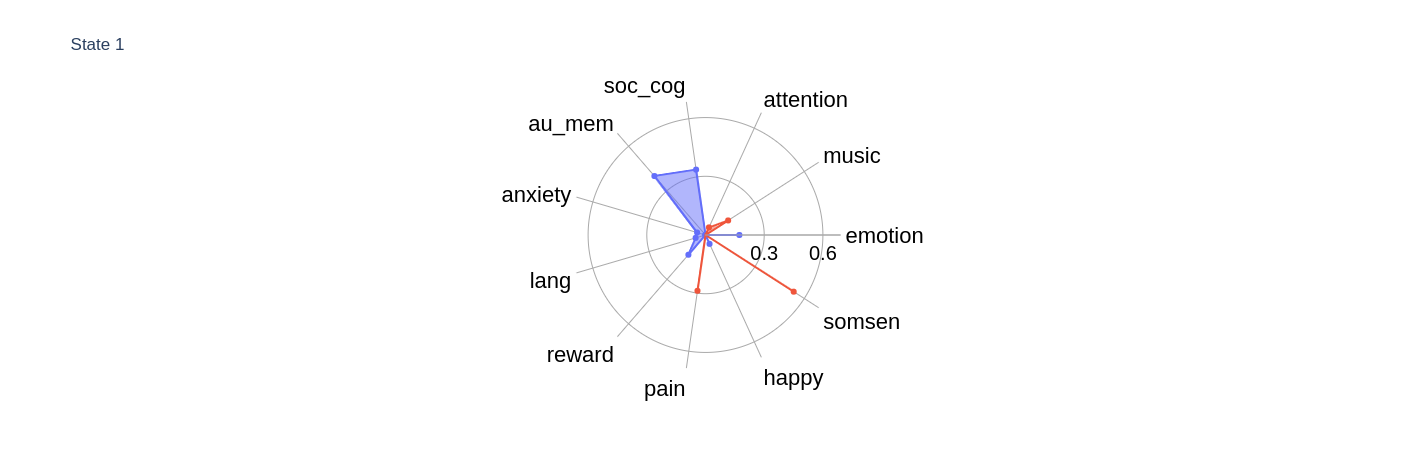

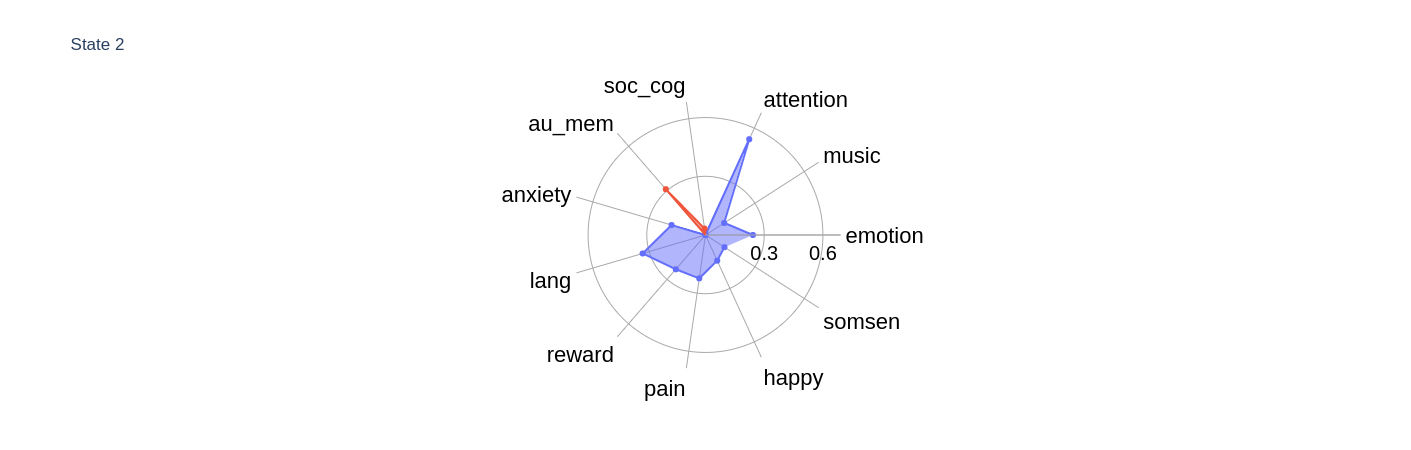

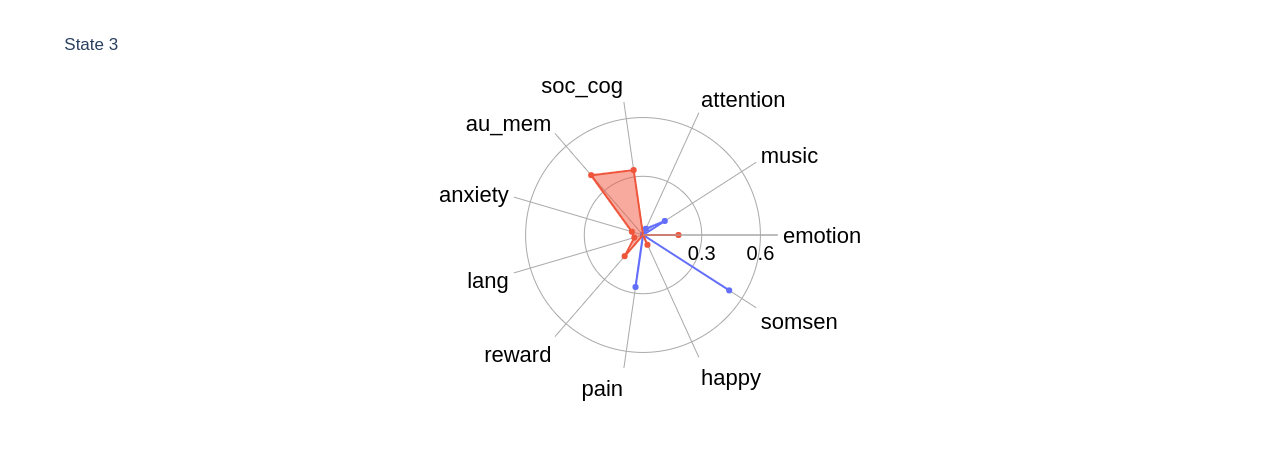

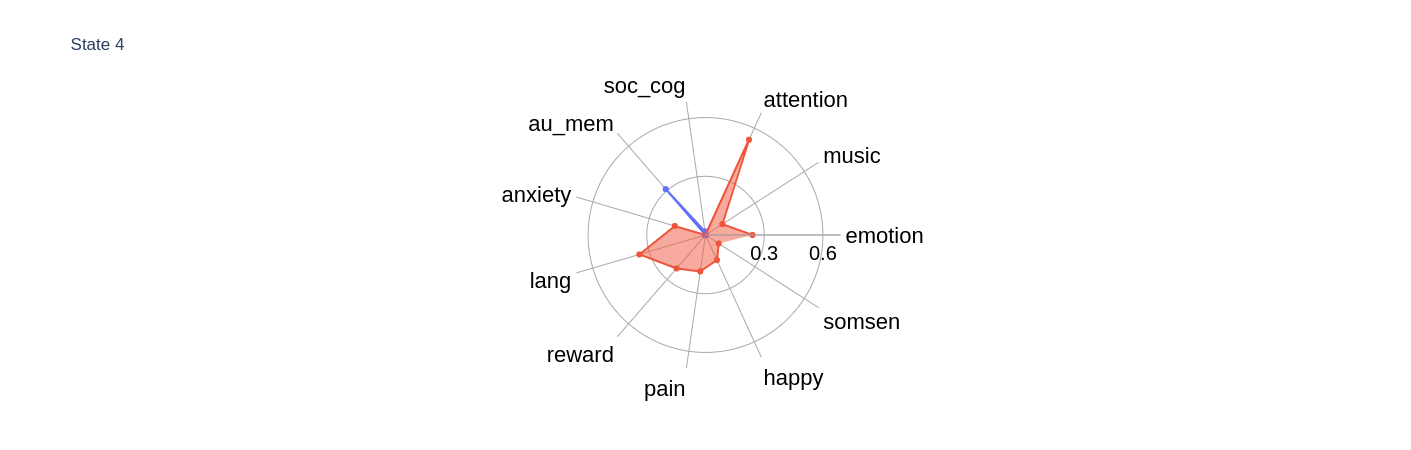

In [10]:
#Loading data
mean_bs_4 = np.load('data/fixed_mean_bs_4.npy')

#Calculating correlation and saving output
ns_dict_4 = pd.DataFrame()

for i in range(4):
    for key, value in neurosynth.items():
        corr_4_ns = pearsonr(mean_bs_4[i], value)[0]
        ns_dict_4 = pd.concat([ns_dict_4, pd.DataFrame({'State': i+1,
                                                    'Topc map': key,
                                                    'Correlation': corr_4_ns
                                                   },index=[0])],axis=0)

        
#Calculating the absolute value of negative correlation
corr_neg_4_ns = []

for i in range(44):
    corr_4 = ns_dict_4.iloc[i]['Correlation']
    if corr_4 < 0:
        corr_neg_4_ns.append(abs(corr_4))
    else:
        corr_neg_4_ns.append(0)
        
#Updating dictionary
ns_dict_4['Correlation_neg'] = corr_neg_4_ns

#Plotting Neurosynth topic maps correlations
maps_names = list(neurosynth.keys())

for i in range(1,5):
    ns_data_4 = ns_dict_4.where(ns_dict_4['State'] == i).dropna()
    corr_pos = np.array(ns_data_4['Correlation'])
    corr_neg = np.array(ns_data_4['Correlation_neg'])
        
    fig = go.Figure()

    fig.add_trace(go.Scatterpolar(r= corr_neg, theta = maps_names, fill='toself',name='Negative correlation'))
    fig.add_trace(go.Scatterpolar(r= corr_pos, theta = maps_names, fill='toself', name='Positive correlation'))

    fig.update_layout(polar=dict(bgcolor = '#ffffff', radialaxis=dict(visible=True,range=[0,0.69], color = '#000000', gridcolor = '#A9A9A9',  linecolor = '#A9A9A9', showline = True, tickvals = [0.3, 0.6], tickfont = dict(size = 20, color = '#000000')), angularaxis = dict(visible = True, color = '#000000', showgrid = True, gridcolor = '#A9A9A9', tickfont = dict(size = 22))),showlegend = False, title = f'State {i}')
   
    fig.update_layout(width = 600)
    fig.update_layout(height= 450)
    fig.show()
